# Recurrent Neural Networks

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Overview

The structure of the direcotry should be as follows:

```
.
├── data
│   ├── train.pkl
│   └── test_no_target.pkl
└── main.ipynb
```



## Setup

Select the device to use

In [1]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Data preparation

Load the data

In [2]:
train_path = "data/train.pkl"

In [3]:
import pickle

with open(train_path, "rb") as f:
    train_data = pickle.load(f)

print(f"Loaded {len(train_data)} training samples.")

Loaded 2939 training samples.


Print sample data

In [4]:
import random


idx = random.randint(0, len(train_data) - 1)
print(f"Sample data: {train_data[idx]}")

Sample data: (array([ -1.,  64.,  36., 112.,  47.,  47.,  12.,  12.,  12.,  47.,  92.,
        12.,  12.,  12.,  92.,  93.,  15.,  15.,  15., 124., 159.,   6.,
        79.,  92.,  45.,  12.,  45., 124.,  12.,  12., 124.,  12., 112.,
       112.,  78.,   2.,  47.,  47.,  12.,  12.,  12.,  47.,  92.,  12.,
        12.,  12.,  92.,  93.,  15.,  15.,  15., 124., 159.,   6.,  79.,
        92.,  45.,  12.,  45., 124.,  12.,  15., 124.,  12., 120., 112.,
         8.,   1.,  77.,  44.,  13., 125., 125.,  44.,  44.,  60., 127.,
       127.,  92., 127., 127.,  60.,  78.,  12.,  12.,  78.,  30.,  47.,
        12.,  47.,  78.,  12.,  12.,  12.,  92.,  92.,  92., 145.,  88.,
         2.,  47.,  47.,  13.,  28.,  28.,  92.,   7.,  92., 172., 127.,
        28.,  28., 127., 158.,  28., 121.,  60.,  60.,  28.,  12.,  12.,
       159.,  77.,  28.,  13.,  28.,  73.,  73.,   0.,   0.,  88.,   1.,
        77.,  44.,  13., 125., 125.,  44.,  44.,  60., 127., 127.,  92.,
       127., 127.,  60.,  78.,  12., 

In [5]:
import numpy as np

sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data]
labels = [label for (seq, label) in train_data]

# Find the max chord index (vocab size, since chords are ints)
all_chords = set()
for seq in sequences:
    all_chords.update(seq.tolist())
vocab_size = int(max(all_chords)) + 2  # +1 for max, +1 for padding idx=0

print(f"Vocab size: {vocab_size}")

Vocab size: 193


Determine the compositors

In [16]:
compositors = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

Prepare the train and test datasets

In [6]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ChordDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=0)
    return padded_seqs, lengths, torch.tensor(labels, dtype=torch.long)

In [7]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256

train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)

train_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data_split]
train_labels = [label for (seq, label) in train_data_split]
val_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in val_data_split]
val_labels = [label for (seq, label) in val_data_split]

In [8]:
train_dataset = ChordDataset(train_sequences, train_labels)
val_dataset = ChordDataset(val_sequences, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## Create the model

In [9]:
import torch.nn as nn

class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout_p=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.rnn(packed)
        h_n = self.dropout(h_n[-1])
        logits = self.fc(h_n)
        return logits

## Train the model

In [10]:
def evaluate(model, val_loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    with torch.no_grad():
        for batch_seqs, batch_lengths, batch_labels in val_loader:
            batch_seqs = batch_seqs.to(device)
            batch_lengths = batch_lengths.to(device)
            batch_labels = batch_labels.to(device)
            logits = model(batch_seqs, batch_lengths)
            loss = criterion(logits, batch_labels)
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == batch_labels).sum().item()
            total_samples += batch_labels.size(0)
            total_loss += loss.item() * batch_seqs.size(0)
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [11]:
EMBED_DIM = 32
HIDDEN_DIM = 64
OUTPUT_DIM = 5
DROPOUT_P = 0

model = SimpleRNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_P).to(device)

In [12]:
counts = torch.tensor([1630, 478, 154, 441, 236], dtype=torch.float)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(counts)  # Normalize to num_classes

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [13]:
from tqdm import tqdm

EPOCHS = 50

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch_seqs, batch_lengths, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_seqs = batch_seqs.to(device)
        batch_lengths = batch_lengths.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        logits = model(batch_seqs, batch_lengths)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_seqs.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == batch_labels).sum().item()
        total_samples += batch_labels.size(0)
    
    avg_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    val_loss, val_acc = evaluate(model, val_loader, device)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50: 100%|██████████| 10/10 [00:50<00:00,  5.10s/it]


Epoch 1/50 | Train Loss: 1.5869 | Train Acc: 0.2493 | Val Loss: 1.5515 | Val Acc: 0.3486


Epoch 2/50: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 2/50 | Train Loss: 1.5194 | Train Acc: 0.3781 | Val Loss: 1.4895 | Val Acc: 0.4320


Epoch 3/50: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 3/50 | Train Loss: 1.4646 | Train Acc: 0.4551 | Val Loss: 1.4340 | Val Acc: 0.4830


Epoch 4/50: 100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


Epoch 4/50 | Train Loss: 1.4070 | Train Acc: 0.4904 | Val Loss: 1.3800 | Val Acc: 0.5221


Epoch 5/50: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Epoch 5/50 | Train Loss: 1.3482 | Train Acc: 0.5202 | Val Loss: 1.3301 | Val Acc: 0.5578


Epoch 6/50: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


Epoch 6/50 | Train Loss: 1.2963 | Train Acc: 0.5623 | Val Loss: 1.2847 | Val Acc: 0.5731


Epoch 7/50: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Epoch 7/50 | Train Loss: 1.2373 | Train Acc: 0.5291 | Val Loss: 1.2121 | Val Acc: 0.5612


Epoch 8/50: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Epoch 8/50 | Train Loss: 1.1626 | Train Acc: 0.5695 | Val Loss: 1.1405 | Val Acc: 0.6259


Epoch 9/50: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


Epoch 9/50 | Train Loss: 1.0669 | Train Acc: 0.6027 | Val Loss: 1.0170 | Val Acc: 0.6514


Epoch 10/50: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 10/50 | Train Loss: 0.9810 | Train Acc: 0.6350 | Val Loss: 0.9569 | Val Acc: 0.6497


Epoch 11/50: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


Epoch 11/50 | Train Loss: 0.9078 | Train Acc: 0.6576 | Val Loss: 0.8794 | Val Acc: 0.6939


Epoch 12/50: 100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


Epoch 12/50 | Train Loss: 0.8402 | Train Acc: 0.6823 | Val Loss: 0.8037 | Val Acc: 0.7075


Epoch 13/50: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Epoch 13/50 | Train Loss: 0.7863 | Train Acc: 0.6899 | Val Loss: 0.7713 | Val Acc: 0.7347


Epoch 14/50: 100%|██████████| 10/10 [00:47<00:00,  4.80s/it]


Epoch 14/50 | Train Loss: 0.7467 | Train Acc: 0.7116 | Val Loss: 0.7627 | Val Acc: 0.7075


Epoch 15/50: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 15/50 | Train Loss: 0.6981 | Train Acc: 0.7210 | Val Loss: 0.7130 | Val Acc: 0.7211


Epoch 16/50: 100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Epoch 16/50 | Train Loss: 0.6562 | Train Acc: 0.7444 | Val Loss: 0.6719 | Val Acc: 0.7534


Epoch 17/50: 100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


Epoch 17/50 | Train Loss: 0.6182 | Train Acc: 0.7631 | Val Loss: 0.6620 | Val Acc: 0.7670


Epoch 18/50: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


Epoch 18/50 | Train Loss: 0.5810 | Train Acc: 0.7877 | Val Loss: 0.6178 | Val Acc: 0.7942


Epoch 19/50: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 19/50 | Train Loss: 0.5329 | Train Acc: 0.8035 | Val Loss: 0.6094 | Val Acc: 0.7874


Epoch 20/50: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Epoch 20/50 | Train Loss: 0.4949 | Train Acc: 0.8141 | Val Loss: 0.5948 | Val Acc: 0.8112


Epoch 21/50: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


Epoch 21/50 | Train Loss: 0.5040 | Train Acc: 0.7988 | Val Loss: 0.6871 | Val Acc: 0.8248


Epoch 22/50: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 22/50 | Train Loss: 0.5308 | Train Acc: 0.7843 | Val Loss: 0.6333 | Val Acc: 0.7483


Epoch 23/50: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Epoch 23/50 | Train Loss: 0.4946 | Train Acc: 0.8167 | Val Loss: 0.6179 | Val Acc: 0.7806


Epoch 24/50: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 24/50 | Train Loss: 0.4446 | Train Acc: 0.8252 | Val Loss: 0.5749 | Val Acc: 0.7976


Epoch 25/50: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]


Epoch 25/50 | Train Loss: 0.4141 | Train Acc: 0.8418 | Val Loss: 0.4979 | Val Acc: 0.8299


Epoch 26/50: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Epoch 26/50 | Train Loss: 0.3739 | Train Acc: 0.8545 | Val Loss: 0.4962 | Val Acc: 0.8452


Epoch 27/50: 100%|██████████| 10/10 [00:45<00:00,  4.60s/it]


Epoch 27/50 | Train Loss: 0.3453 | Train Acc: 0.8652 | Val Loss: 0.4659 | Val Acc: 0.8469


Epoch 28/50: 100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Epoch 28/50 | Train Loss: 0.3411 | Train Acc: 0.8647 | Val Loss: 0.4586 | Val Acc: 0.8520


Epoch 29/50: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Epoch 29/50 | Train Loss: 0.3061 | Train Acc: 0.8843 | Val Loss: 0.4201 | Val Acc: 0.8622


Epoch 30/50: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Epoch 30/50 | Train Loss: 0.3019 | Train Acc: 0.8864 | Val Loss: 0.4229 | Val Acc: 0.8418


Epoch 31/50: 100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


Epoch 31/50 | Train Loss: 0.2800 | Train Acc: 0.8924 | Val Loss: 0.3907 | Val Acc: 0.8724


Epoch 32/50: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Epoch 32/50 | Train Loss: 0.2524 | Train Acc: 0.9060 | Val Loss: 0.4373 | Val Acc: 0.8503


Epoch 33/50: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Epoch 33/50 | Train Loss: 0.2574 | Train Acc: 0.9022 | Val Loss: 0.4646 | Val Acc: 0.8690


Epoch 34/50: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Epoch 34/50 | Train Loss: 0.2451 | Train Acc: 0.9115 | Val Loss: 0.3916 | Val Acc: 0.8656


Epoch 35/50: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 35/50 | Train Loss: 0.2251 | Train Acc: 0.9115 | Val Loss: 0.3980 | Val Acc: 0.8486


Epoch 36/50: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 36/50 | Train Loss: 0.2290 | Train Acc: 0.9124 | Val Loss: 0.4059 | Val Acc: 0.8724


Epoch 37/50: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Epoch 37/50 | Train Loss: 0.2258 | Train Acc: 0.9141 | Val Loss: 0.3946 | Val Acc: 0.8793


Epoch 38/50: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 38/50 | Train Loss: 0.1944 | Train Acc: 0.9222 | Val Loss: 0.4126 | Val Acc: 0.8878


Epoch 39/50: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 39/50 | Train Loss: 0.2017 | Train Acc: 0.9188 | Val Loss: 0.3918 | Val Acc: 0.8827


Epoch 40/50: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epoch 40/50 | Train Loss: 0.1925 | Train Acc: 0.9205 | Val Loss: 0.4465 | Val Acc: 0.8759


Epoch 41/50: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Epoch 41/50 | Train Loss: 0.1954 | Train Acc: 0.9149 | Val Loss: 0.3843 | Val Acc: 0.8827


Epoch 42/50: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Epoch 42/50 | Train Loss: 0.1725 | Train Acc: 0.9302 | Val Loss: 0.3799 | Val Acc: 0.8810


Epoch 43/50: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Epoch 43/50 | Train Loss: 0.1923 | Train Acc: 0.9256 | Val Loss: 0.4429 | Val Acc: 0.8418


Epoch 44/50: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


Epoch 44/50 | Train Loss: 0.1946 | Train Acc: 0.9171 | Val Loss: 0.3820 | Val Acc: 0.8690


Epoch 45/50: 100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


Epoch 45/50 | Train Loss: 0.1595 | Train Acc: 0.9379 | Val Loss: 0.4096 | Val Acc: 0.8793


Epoch 46/50: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


Epoch 46/50 | Train Loss: 0.1534 | Train Acc: 0.9379 | Val Loss: 0.4046 | Val Acc: 0.8759


Epoch 47/50: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


Epoch 47/50 | Train Loss: 0.1475 | Train Acc: 0.9400 | Val Loss: 0.4333 | Val Acc: 0.8759


Epoch 48/50: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Epoch 48/50 | Train Loss: 0.1358 | Train Acc: 0.9451 | Val Loss: 0.4657 | Val Acc: 0.8776


Epoch 49/50: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Epoch 49/50 | Train Loss: 0.1258 | Train Acc: 0.9524 | Val Loss: 0.4421 | Val Acc: 0.8759


Epoch 50/50: 100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


Epoch 50/50 | Train Loss: 0.1264 | Train Acc: 0.9481 | Val Loss: 0.4483 | Val Acc: 0.8759


## Evaluate the results

Check the true and false positives per class

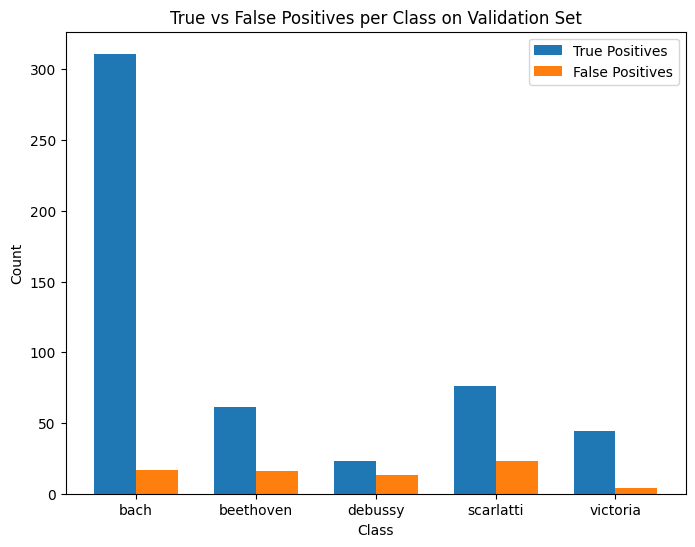

In [17]:
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for seqs, lengths, labels in val_loader:
        seqs = seqs.to(device)
        lengths = lengths.to(device)
        logits = model(seqs, lengths)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute true positives and false positives per class
num_classes = OUTPUT_DIM
tp = np.zeros(num_classes, dtype=int)
fp = np.zeros(num_classes, dtype=int)
for pred, true in zip(all_preds, all_labels):
    if pred == true:
        tp[pred] += 1
    else:
        fp[pred] += 1

# Plot
x = np.arange(num_classes)
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, tp, width, label='True Positives')
ax.bar(x + width/2, fp, width, label='False Positives')
ax.set_xticks(x)
ax.set_xticklabels([compositors[i] for i in range(num_classes)])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('True vs False Positives per Class on Validation Set')
ax.legend()
plt.show()

Check the average class accuracy

In [21]:
# Calculate average accuracy per class
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
num_classes = OUTPUT_DIM

avg_acc_per_class = {}
for i in range(num_classes):
    mask = all_labels == i
    total = mask.sum()
    correct = (all_preds[mask] == i).sum()
    avg_acc_per_class[compositors[i]] = correct / total if total > 0 else 0.0

for comp, acc in avg_acc_per_class.items():
    print(f"{comp}: {acc:.4f}")

avg_overall_acc = np.mean(list(avg_acc_per_class.values()))
print(f"Average overall accuracy: {avg_overall_acc:.4f}")

bach: 0.9367
beethoven: 0.7262
debussy: 0.8519
scarlatti: 0.7755
victoria: 0.9362
Average overall accuracy: 0.8453
